In [ ]:
#import os

In [ ]:
#label=os.listdir(rootdir)

In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=4ee74879f2b8d25655b20cf80c33b62cf9a4e072ae314c18c26d8a584985c9a9
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
import numpy
import os
import librosa
import scipy
import sklearn
import tensorflow
import imblearn
import librosa.display
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from sklearn.preprocessing import StandardScaler
#from imbalanced-learn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
imblearn.__version__

'0.10.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files=[]
labels=[]

In [ ]:
#!mkdir '/content/drive/My Drive/Colab Notebooks/dest'
!pip install rarfile
from rarfile import RarFile

In [ ]:
with RarFile('/content/drive/MyDrive/fssd_word_wise.rar','r') as rarObj:
    rarObj.extractall('/drive/MyDrive/test')

In [ ]:
path ='/drive/MyDrive/test/fssd_word_wise'

In [ ]:
#path ="E:\DNN_Bengali_Numbers\zero2-99"
#we shall store all the file names in this list
separator = '/'
filelist = []
labels=[]
for root, dirs, files in os.walk(path):
    #for dirss in dirs:
        for file in files:
        #append the file name to the list
            filelist.append(os.path.join(root,file))
            string = os.path.join(root,file)
            st =string[35:-1]
            st = st.split(separator,1)[0]
            labels.append(st)
               #print all the file names
#for name in filelist:
#    print(name)

In [ ]:
filelist = numpy.array(filelist)
labels = numpy.array(labels)

In [ ]:
def mfcc_features(filelist, labels):
    features = []
    for name in filelist:
            #if wav and wave_name are equal
            #extract mfcc features and append them to features
            #append label to labels
            (rate,sig) = wav.read(name)
            mfcc_feat = mfcc(sig,rate, numcep=18, nfft=256)

            features.append(mfcc_feat)
    return features, labels


In [ ]:
mfcc_feat = mfcc_features(filelist, labels)

In [ ]:
MFCC_features, MFCC_labels = mfcc_feat

In [ ]:
#MFCC_features = numpy.array(MFCC_features)
#labels = numpy.array(labels)

In [ ]:
print("shape of extracted mfcc features:", MFCC_features[1].shape)
print("shape of extracted mfcc labels:", MFCC_labels.shape)

shape of extracted mfcc features: (39, 18)
shape of extracted mfcc labels: (3000,)


In [ ]:
def zero_pad(features):

    new_spoken_train = []
    max_shape = 0
    min_shape = 1000
    for x in features:
        all_shapes = x.shape[0]
        if all_shapes > max_shape:
            max_shape = all_shapes

    for x in features:
        difference = max_shape-x.shape[0]
        zero_padded = numpy.pad(x,((0,difference),(0,0)), "constant")
        new_spoken_train.append(zero_padded)

    new_spoken_train = numpy.array(new_spoken_train)

    return new_spoken_train

In [ ]:
new_spoken_train = zero_pad(MFCC_features)

In [ ]:
new_spoken_train[0].shape

(227, 18)

In [ ]:
print(new_spoken_train.shape)

(3000, 227, 18)


In [ ]:
new_spoken_train = numpy.reshape(new_spoken_train,(new_spoken_train.shape[0],4086))

In [ ]:
new_spoken_train.shape

(3000, 4086)

In [ ]:
scaler = StandardScaler()
scaler.fit(new_spoken_train)
new_spoken_train = scaler.fit_transform(new_spoken_train)

In [ ]:
ros = SMOTE(random_state=42)
new_mfcc_features,  mfcc_labels = ros.fit_resample(new_spoken_train, MFCC_labels)

dictionary_2 = {}
for i in mfcc_labels:
    dictionary_2[i] = dictionary_2.get(i,0) + 1

print(dictionary_2)

{'four': 300, 'six': 300, 'zero': 300, 'seven': 300, 'eight': 300, 'two': 300, 'one': 300, 'three': 300, 'nine': 300, 'five': 300}


In [ ]:
new_mfcc_features = numpy.reshape(new_mfcc_features,(new_mfcc_features.shape[0],4086))

In [ ]:
print(new_mfcc_features.shape)
print(mfcc_labels.shape)

(3000, 4086)
(3000,)


In [ ]:
new_spoken_train = numpy.reshape(new_mfcc_features,(new_mfcc_features.shape[0],227,18))

In [ ]:
def one_hot_encoder(labels):
    values = array(labels)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    return onehot_encoded

one_hot_encoded_labels = one_hot_encoder(mfcc_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_spoken_train,
                                                    one_hot_encoded_labels,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify = one_hot_encoded_labels)#, Suffle= True)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model

from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

input_shape=Input(shape=(227,18,1))
#input_img = Input(shape=(height, width, channel))

'''x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(input_shape)
x = L.BatchNormalization()(x)
#x = L.Conv2D(5, (5, 1), activation='relu', padding='same')(input_shape)
#x = L.BatchNormalization()(x)
x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

x = L.Bidirectional(L.LSTM(32, return_sequences=True))(
        x)  # [b_s, seq_len, vec_dim]
x = L.Bidirectional(L.LSTM(32, return_sequences=True))(x)
#xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
#query = L.Dense(64)(xFirst)
#attScores = L.Dot(axes=[1, 2])([query, x])
#attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
#attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]
x = L.Flatten()(x)
x = L.Dense(32, activation='relu')(x)
x = L.Dense(16,activation='relu')(x)

#x = L.Dense(64, activation='relu')(x)
#x = L.Dense(32, activation='relu')(x)

output = L.Dense(10, activation='softmax')(x)

model = Model(inputs=[input_shape], outputs=[output])

model.summary()'''
x = L.Conv2D(16, (2, 2), activation='relu', padding='same', strides=1)(input_shape)
#x = L.MaxPooling2D(2,2)(x)
x = L.Dropout(0.3)(x)
x = L.BatchNormalization()(x)
x = L.Conv2D(8, (2,2), activation='relu', padding='same')(x)
x = L.Dropout(0.3)(x)
x = L.BatchNormalization()(x)
x = L.Conv2D(1, (2,2), activation='relu', padding='same')(x)
x = L.BatchNormalization()(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

x = L.Bidirectional(L.LSTM(64, return_sequences=True))(
        x)  # [b_s, seq_len, vec_dim]
x = L.Bidirectional(L.LSTM(32))(x)
#xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
#query = L.Dense(64)(xFirst)
#attScores = L.Dot(axes=[1, 2])([query, x])
#attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
#attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]
#x = L.Flatten()(x)
x = L.Dense(32, activation='relu')(x)
x = L.Dense(16,activation='relu')(x)

#x = L.Dense(64, activation='relu')(x)
#x = L.Dense(32, activation='relu')(x)

output = L.Dense(10, activation='softmax')(x)

model = Model(inputs=[input_shape], outputs=[output])

#output = L.Dense(10, activation='softmax')(x)

#model = Model(inputs=[input_shape], outputs=[output])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 18, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 227, 18, 16)       80        
                                                                 
 dropout (Dropout)           (None, 227, 18, 16)       0         
                                                                 
 batch_normalization (Batch  (None, 227, 18, 16)       64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 227, 18, 8)        520       
                                                                 
 dropout_1 (Dropout)         (None, 227, 18, 8)        0         
                                                             

In [ ]:
one_hot_encoded_labels.shape
#mfcc_labels.shape
#new_spoken_train.shape

(3000, 10)

In [ ]:
new_spoken_train = numpy.reshape(new_spoken_train,(new_spoken_train.shape[0],227,18))
new_spoken_train.shape
#one_hot_encoded_labels

(3000, 227, 18)

In [ ]:
model.compile(loss= "categorical_crossentropy",
              optimizer= Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import numpy as np


#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('model_fsdd_mfcc_18.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=64, n=1):
    if n<=5:
        pat = 10 #this is the number of epochs with no improvment after which the training will stop
    else:
        pat = 3
    early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
    #model = None
    #model = cnn_model(IMAGE_SIZE, 2)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint],
              verbose=1, validation_split=0.1)
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
import time, datetime
start = datetime.datetime.now()
n_folds=10
epochs=100
batch_size=64

#save the model history in a list after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train,y_train, test_size=0.10,
                                               random_state = np.random.randint(1,1000, 1)[0],stratify=y_train)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size,i+1))
    print("======="*12, end="\n\n\n")
end = datetime.datetime.now()
diff = (end - start)
diff_seconds = int(diff.total_seconds())
minute_seconds, seconds = divmod(diff_seconds, 60)
hours, minutes = divmod(minute_seconds, 60)
hms = f"{hours}h {minutes}m {seconds}s"
print(hms)

Training on Fold:  1
Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 2.1851 - accuracy: 0.1790
Epoch 1: val_loss improved from inf to 2.05288, saving model to model_fsdd_mfcc_18.h5
31/31 [==============================] - 16s 101ms/step - loss: 2.1851 - accuracy: 0.1790 - val_loss: 2.0529 - val_accuracy: 0.2222
Epoch 2/100
 3/31 [=>............................] - ETA: 1s - loss: 1.9376 - accuracy: 0.2396

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 1.6668 - accuracy: 0.3724
Epoch 2: val_loss improved from 2.05288 to 1.50524, saving model to model_fsdd_mfcc_18.h5
31/31 [==============================] - 1s 42ms/step - loss: 1.6668 - accuracy: 0.3724 - val_loss: 1.5052 - val_accuracy: 0.4213
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.5720
Epoch 3: val_loss improved from 1.50524 to 0.99362, saving model to model_fsdd_mfcc_18.h5
31/31 [==============================] - 1s 42ms/step - loss: 1.1481 - accuracy: 0.5720 - val_loss: 0.9936 - val_accuracy: 0.6157
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.7505
Epoch 4: val_loss improved from 0.99362 to 0.60685, saving model to model_fsdd_mfcc_18.h5
31/31 [==============================] - 1s 42ms/step - loss: 0.7906 - accuracy: 0.7505 - val_loss: 0.6068 - val_accuracy: 0.8796
Epoch 5/100
31/31 [==============================] - ETA: 0s - loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9964
Epoch 2: val_loss did not improve from 0.00239
31/31 [==============================] - 1s 41ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9959
Epoch 3: val_loss did not improve from 0.00239
31/31 [==============================] - 1s 39ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9985
Epoch 4: val_loss did not improve from 0.00239
31/31 [==============================] - 1s 40ms/step - loss: 0.0094 - accuracy: 0.9985 - val_loss: 0.0093 - val_accuracy: 0.9954
Epoch 5/100
31/31 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9933
Epoch 5: val_loss did not improve from 0.00239
31/31 [==============================] - 1s 39ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995
Epoch 12: val_loss improved from 0.00232 to 0.00196, saving model to model_fsdd_mfcc_18.h5
31/31 [==============================] - 1s 44ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 13/100
31/31 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9985
Epoch 13: val_loss did not improve from 0.00196
31/31 [==============================] - 1s 40ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 14/100
31/31 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995
Epoch 14: val_loss did not improve from 0.00196
31/31 [==============================] - 1s 40ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0083 - val_accuracy: 0.9954
Epoch 15/100
31/31 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9969
Epoch 15: val_loss did not improve from 0.00196
31/3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9985
Epoch 4: val_loss did not improve from 0.00063
31/31 [==============================] - 2s 63ms/step - loss: 0.0038 - accuracy: 0.9985 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/100
30/31 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995
Epoch 5: val_loss did not improve from 0.00063
31/31 [==============================] - 2s 52ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 6/100
30/31 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9984
Epoch 6: val_loss did not improve from 0.00063
31/31 [==============================] - 1s 46ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 9.0262e-04 - val_accuracy: 1.0000
Epoch 7/100
31/31 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9979
Epoch 7: val_loss did not improve from 0.00063
31/31 [==============================] - 1s 40ms/s

In [ ]:
avg_val_acc = 0
for i in range(10):
    avg_val_acc = avg_val_acc + model_history[i].history['val_accuracy'][-1]
avg_val_acc = avg_val_acc /10
print(avg_val_acc)
#print(model_history[i].history['val_accuracy'][-1]*100)

0.9939814805984497


In [ ]:
for i in range(10):
    print(model_history[i].history['val_accuracy'][-1])

0.9675925970077515
0.9861111044883728
0.9768518805503845
1.0
1.0
0.9953703880310059
0.9953703880310059
1.0
1.0
1.0


In [ ]:
for i in range(10):
    print(model_history[i].history['val_loss'][-1])

0.1435183882713318
0.0641418993473053
0.07661741971969604
0.001472541014663875
0.00025030632968991995
0.006730027962476015
0.02754666842520237
0.0008741318015381694
0.0024792428594082594
4.692251604865305e-05


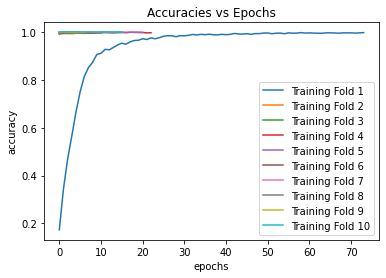

In [ ]:
plt.title('Accuracies vs Epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['accuracy'], label='Training Fold 5')
#plt.plot(model_history[5].history['accuracy'], label='Training Fold 6')
#plt.plot(model_history[6].history['accuracy'], label='Training Fold 7')
#plt.plot(model_history[7].history['accuracy'], label='Training Fold 8')
#plt.plot(model_history[8].history['accuracy'], label='Training Fold 9')
#plt.plot(model_history[9].history['accuracy'], label='Training Fold 10')
plt.legend()
plt.show()

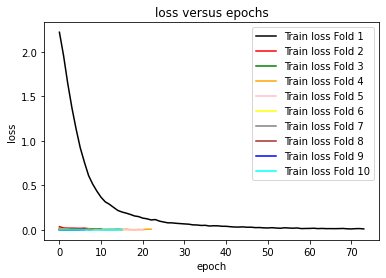

In [ ]:
plt.plot(model_history[0].history['loss'],label='Train loss Fold 1', color='black')
#plt.plot(model_history[0].history['val_loss'],label='Val loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train loss Fold 2', color='red')
#plt.plot(model_history[1].history['val_loss'],label='Val loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'],label='Train loss Fold 3', color='green')
#plt.plot(model_history[2].history['val_loss'],label='Val loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'],label='Train loss Fold 4', color='orange')
#plt.plot(model_history[3].history['val_loss'],label='Val loss Fold 4', color='orange', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'],label='Train loss Fold 5', color='pink')
#plt.plot(model_history[4].history['val_loss'],label='Val loss Fold 5', color='pink', linestyle = "dashdot")
plt.plot(model_history[5].history['loss'],label='Train loss Fold 6', color='yellow')
plt.plot(model_history[6].history['loss'],label='Train loss Fold 7', color='gray')
plt.plot(model_history[7].history['loss'],label='Train loss Fold 8', color='brown')
plt.plot(model_history[8].history['loss'],label='Train loss Fold 9', color='blue')
plt.plot(model_history[9].history['loss'],label='Train loss Fold 10', color='cyan')
plt.title('loss versus epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.legend()
plt.show()

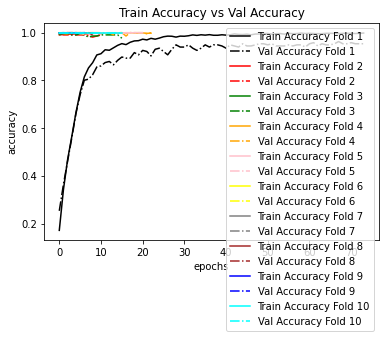

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='orange', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='orange', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='pink', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='pink', linestyle = "dashdot")
plt.plot(model_history[5].history['accuracy'], label='Train Accuracy Fold 6', color='yellow', )
plt.plot(model_history[5].history['val_accuracy'], label='Val Accuracy Fold 6', color='yellow', linestyle = "dashdot")
plt.plot(model_history[6].history['accuracy'], label='Train Accuracy Fold 7', color='gray', )
plt.plot(model_history[6].history['val_accuracy'], label='Val Accuracy Fold 7', color='gray', linestyle = "dashdot")
plt.plot(model_history[7].history['accuracy'], label='Train Accuracy Fold 8', color='brown', )
plt.plot(model_history[7].history['val_accuracy'], label='Val Accuracy Fold 8', color='brown', linestyle = "dashdot")
plt.plot(model_history[8].history['accuracy'], label='Train Accuracy Fold 9', color='blue', )
plt.plot(model_history[8].history['val_accuracy'], label='Val Accuracy Fold 9', color='blue', linestyle = "dashdot")
plt.plot(model_history[9].history['accuracy'], label='Train Accuracy Fold 10', color='cyan', )
plt.plot(model_history[9].history['val_accuracy'], label='Val Accuracy Fold 10', color='cyan', linestyle = "dashdot")
plt.legend()
plt.show()

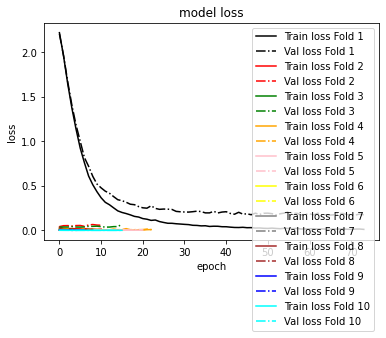

In [ ]:
plt.plot(model_history[0].history['loss'],label='Train loss Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'],label='Val loss Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train loss Fold 2', color='red')
plt.plot(model_history[1].history['val_loss'],label='Val loss Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'],label='Train loss Fold 3', color='green')
plt.plot(model_history[2].history['val_loss'],label='Val loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'],label='Train loss Fold 4', color='orange')
plt.plot(model_history[3].history['val_loss'],label='Val loss Fold 4', color='orange', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'],label='Train loss Fold 5', color='pink')
plt.plot(model_history[4].history['val_loss'],label='Val loss Fold 5', color='pink', linestyle = "dashdot")
plt.plot(model_history[5].history['loss'],label='Train loss Fold 6', color='yellow')
plt.plot(model_history[5].history['val_loss'],label='Val loss Fold 6', color='yellow', linestyle = "dashdot")
plt.plot(model_history[6].history['loss'],label='Train loss Fold 7', color='gray')
plt.plot(model_history[6].history['val_loss'],label='Val loss Fold 7', color='gray', linestyle = "dashdot")
plt.plot(model_history[7].history['loss'],label='Train loss Fold 8', color='brown')
plt.plot(model_history[7].history['val_loss'],label='Val loss Fold 8', color='brown', linestyle = "dashdot")
plt.plot(model_history[8].history['loss'],label='Train loss Fold 9', color='blue')
plt.plot(model_history[8].history['val_loss'],label='Val loss Fold 9', color='blue', linestyle = "dashdot")
plt.plot(model_history[9].history['loss'],label='Train loss Fold 10', color='cyan')
plt.plot(model_history[9].history['val_loss'],label='Val loss Fold 10', color='cyan', linestyle = "dashdot")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.legend()
plt.show()

In [ ]:
result = model.evaluate(X_test, y_test)
print("validation accuracy:", result[1])

19/19 [==============================] - 0s 23ms/step - loss: 0.0513 - accuracy: 0.9933
validation accuracy: 0.9933333396911621


In [ ]:
yy_test = model.predict(X_test)

19/19 [==============================] - 2s 18ms/step


In [ ]:
yy_test=numpy.argmax(yy_test,1)

In [ ]:
val_y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
from sklearn.metrics import confusion_matrix
#import audioUtils
cm = confusion_matrix(numpy.argmax(y_test,1),yy_test)

In [ ]:
classes= ['Eight','Five','Four','Nine','One', 'Seven','Six','Three','Two','Zero']

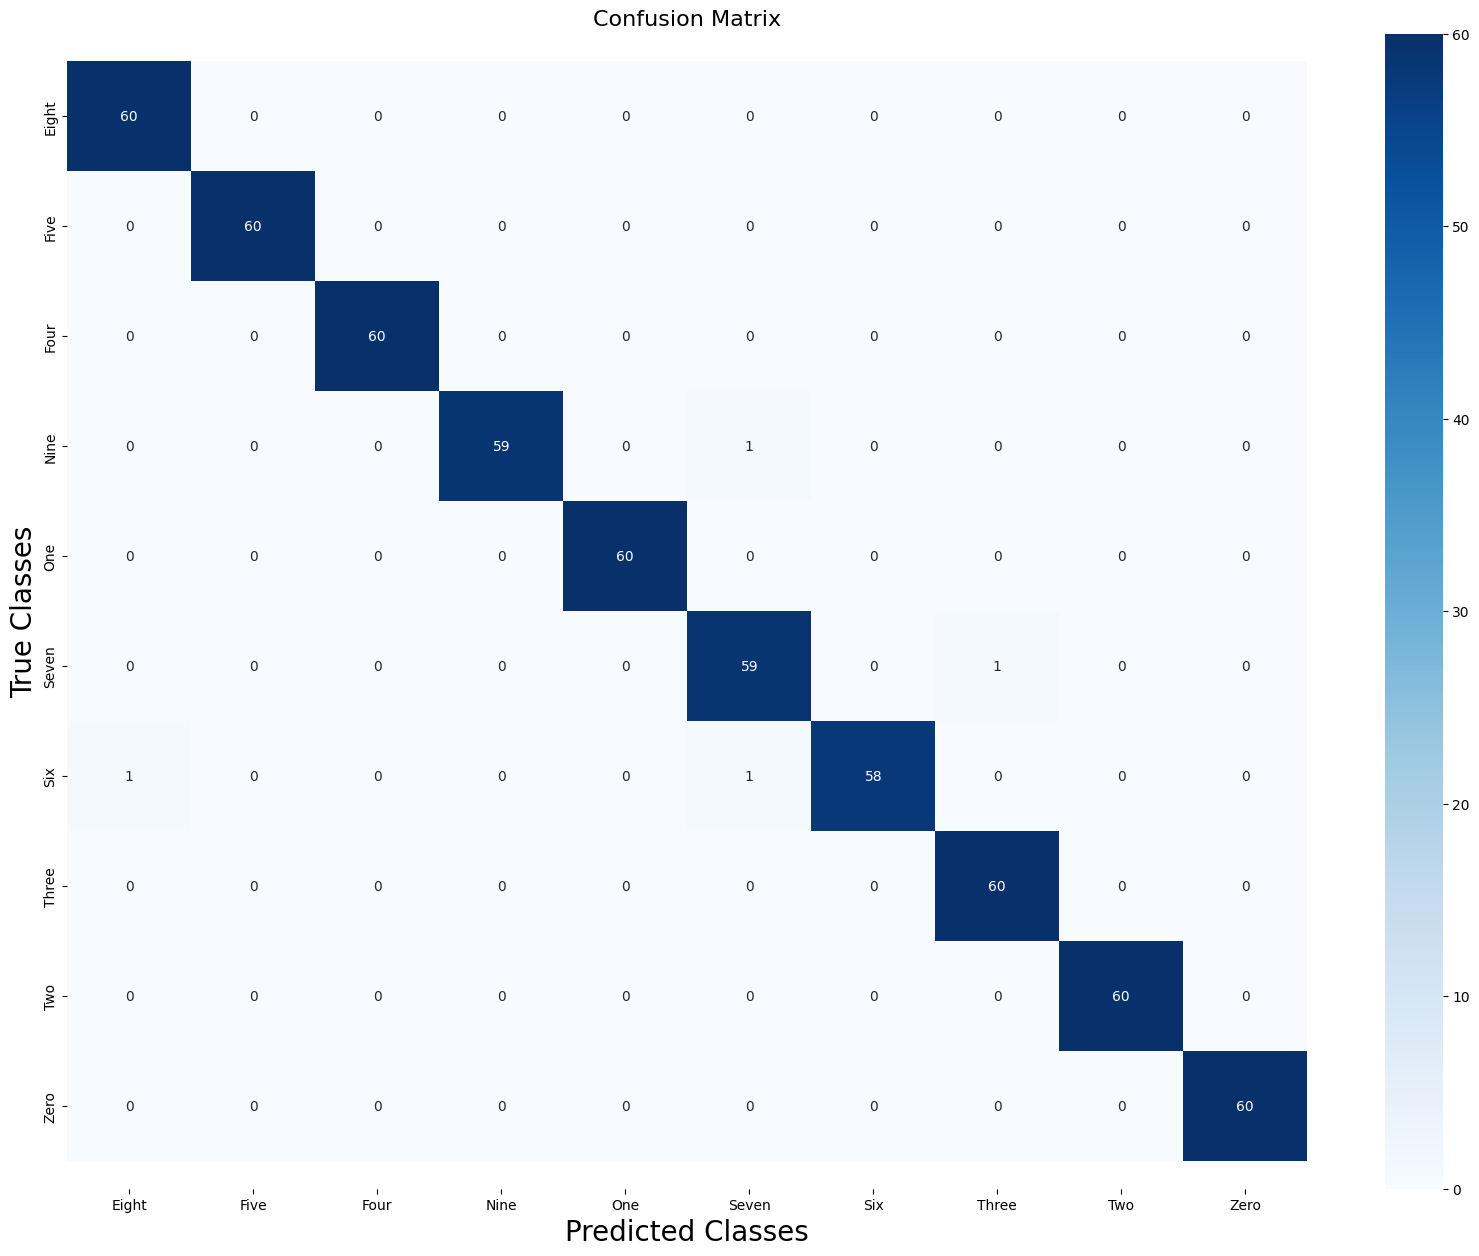

In [ ]:
import seaborn as sn
import pandas as pd
import numpy as np

df_cm = pd.DataFrame(np.array(cm), index = [i for i in classes],
                  columns = [i for i in classes])
#df_cm = someDataFrame.corr()
plt.figure(figsize = (20,15))
ax = sn.heatmap(df_cm, annot=True,fmt="d",cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.25, top - 0.25)
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Classes"     , fontsize=20)
plt.xlabel("Predicted Classes", fontsize=20)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,1),yy_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        60
           3       1.00      0.98      0.99        60
           4       1.00      1.00      1.00        60
           5       0.97      0.98      0.98        60
           6       1.00      0.97      0.98        60
           7       0.98      1.00      0.99        60
           8       1.00      1.00      1.00        60
           9       1.00      1.00      1.00        60

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



In [ ]:
result = model.evaluate(new_spoken_train,one_hot_encoded_labels)

94/94 [==============================] - 1s 15ms/step - loss: 0.0107 - accuracy: 0.9987


In [ ]:
y_test = model.predict(new_spoken_train)
yy_test=numpy.argmax(y_test,1)

94/94 [==============================] - 1s 14ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
#import audioUtils
cm = confusion_matrix(yy_test, numpy.argmax(one_hot_encoded_labels,1))

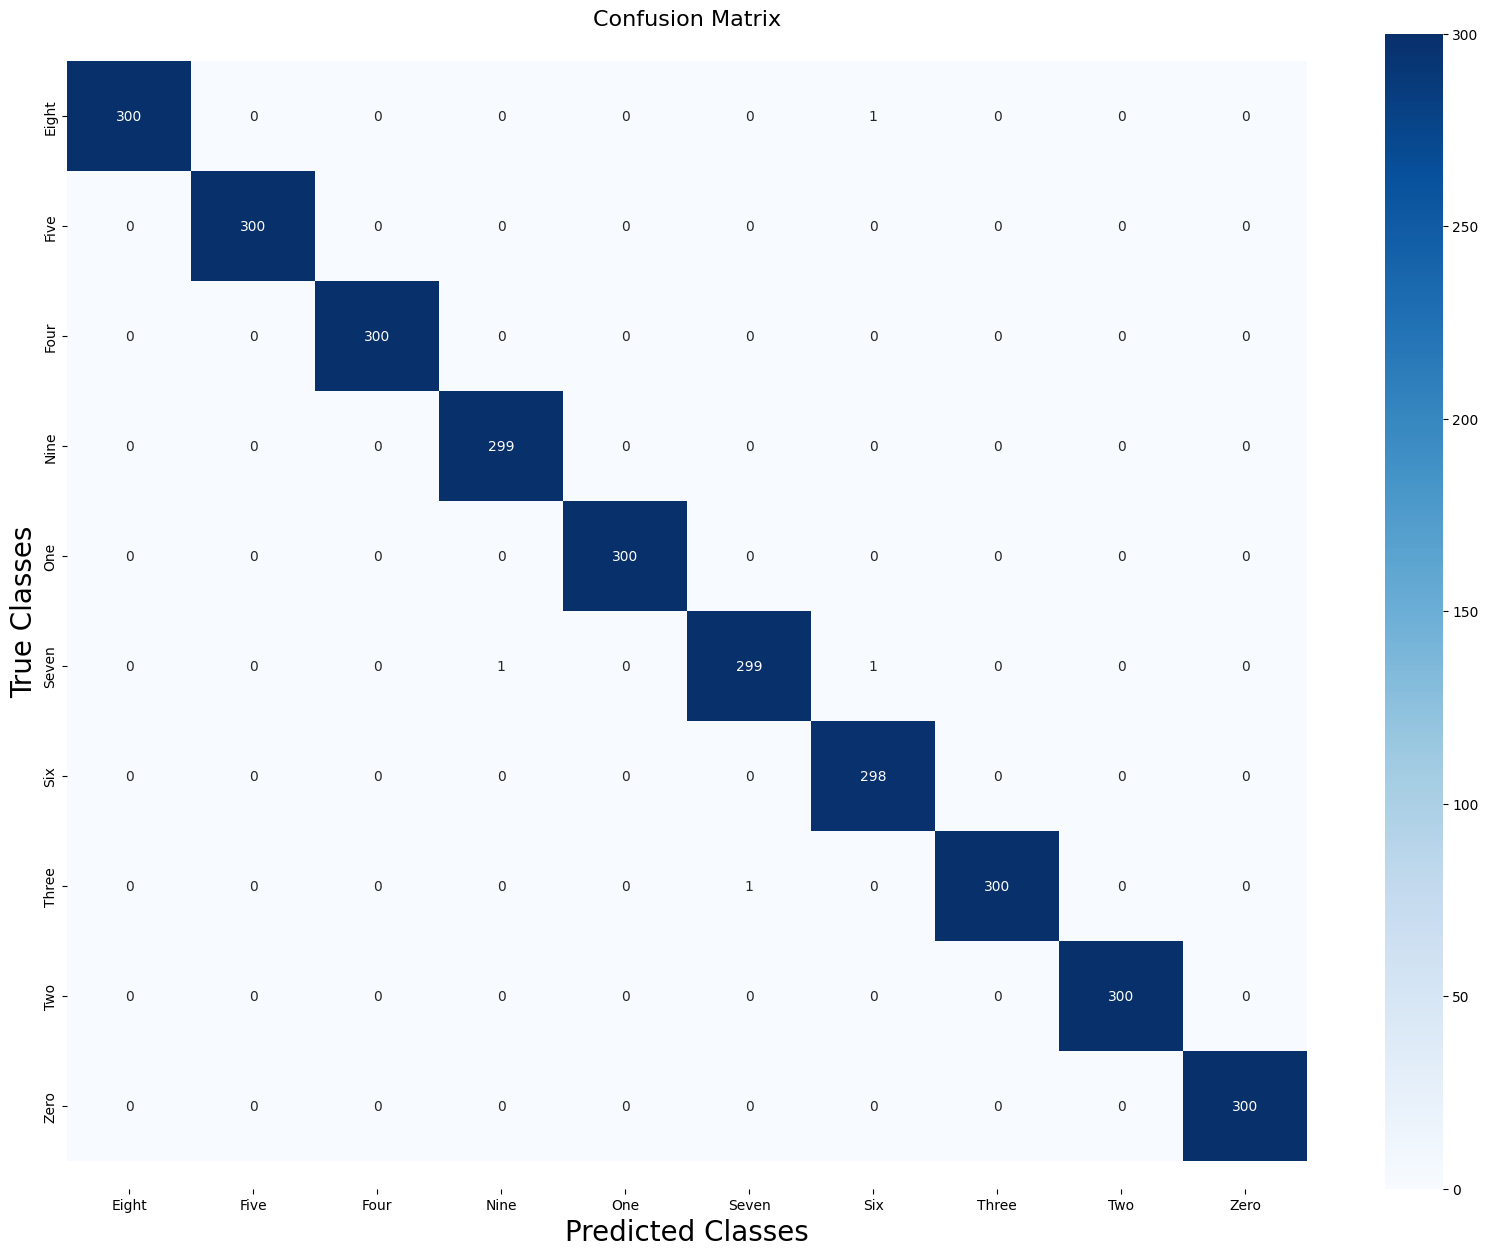

In [ ]:
import seaborn as sn
import pandas as pd
import numpy as np

df_cm = pd.DataFrame(np.array(cm), index = [i for i in classes],
                  columns = [i for i in classes])
#df_cm = someDataFrame.corr()
plt.figure(figsize = (20,15))
ax = sn.heatmap(df_cm, annot=True,fmt="d",cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.25, top - 0.25)
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Classes"     , fontsize=20)
plt.xlabel("Predicted Classes", fontsize=20)
plt.show()

In [ ]:
print(classification_report(yy_test,np.argmax(one_hot_encoded_labels,1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       301
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       299
           4       1.00      1.00      1.00       300
           5       1.00      0.99      1.00       301
           6       0.99      1.00      1.00       298
           7       1.00      1.00      1.00       301
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
model_history[0].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
#!pip install sounddevice

In [ ]:
'''import sounddevice as sd
import soundfile as sf

samplerate = 8000
duration = 1 # seconds
filename = 'record_file.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)'''

'import sounddevice as sd\nimport soundfile as sf\n\nsamplerate = 8000\nduration = 1 # seconds\nfilename = \'record_file.wav\'\nprint("start")\nmydata = sd.rec(int(samplerate * duration), samplerate=samplerate,\n    channels=1, blocking=True)\nprint("end")\nsd.wait()\nsf.write(filename, mydata, samplerate)'

In [ ]:
filename=filelist[0]
import IPython.display as ipd
samples, sample_rate = librosa.load(filename,sr=8000)
ipd.Audio(samples,rate=8000)

Text(0.5, 0, 'Time')

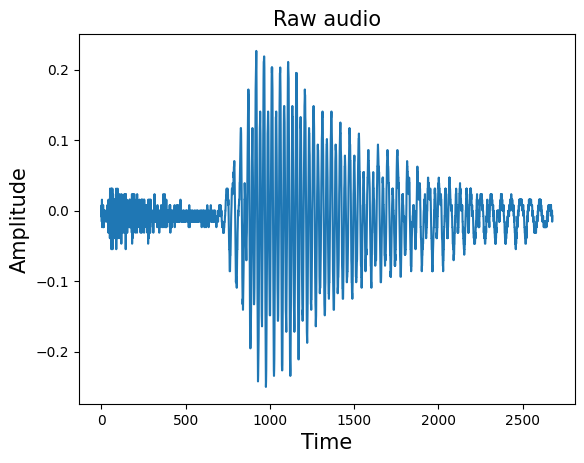

In [ ]:
import matplotlib.pyplot as plt
import librosa
#samples, sample_rate = librosa.load(filename, sr = 16000)
plt.plot(samples)
plt.title('Raw audio', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.xlabel('Time', fontsize=15)

In [ ]:
import numpy as np
input_audio=np.array(samples).reshape(1,len(samples))
import IPython.display as ipd
ipd.Audio(input_audio,rate=8000)

In [ ]:
classes

['Eight',
 'Five',
 'Four',
 'Nine',
 'One',
 'Seven',
 'Six',
 'Three',
 'Two',
 'Zero']

In [ ]:
mfcc_feat[20]

array([ 19.5534574 ,  -3.10118136,  13.6563973 , -14.42923916,
       -38.73434207, -26.09834834,  20.45631156,  -8.54268542,
        -6.73356738,  25.09622633,   4.54538663, -26.02457079,
         0.51999117,  -8.94771484, -12.12726905,  -2.47430441,
        -2.3698168 ,   7.46101075])

In [ ]:
import struct
filename=filelist[1168]
#sig = record(1)
#sig=struct.unpack('f',sig)
rate=8000
(rate,sig) = wav.read(filename)
print(filename)
#print(labels[700])
mfcc_feat = mfcc(sig,rate, numcep=18, nfft=256)
difference = 227-mfcc_feat.shape[0]
#difference
zero_padded = np.pad(mfcc_feat,((0,difference),(0,0)), "constant")
#zero_padded =zero_padded.reshape(1,227,18)
#zero_padded.shape
zero_padded =zero_padded.reshape(1,227,18)



/drive/MyDrive/test/fssd_word_wise/seven/7_george_11.wav


In [ ]:
#zero_padded=np.array(zero_padded)
#zero_padded = numpy.reshape(zero_padded,(1,4086))
#scaler.fit(zero_padded)
#zero_padded = scaler.fit_transform(zero_padded)
#zero_padded = numpy.reshape(zero_padded,(zero_padded.shape[0],227,18))
pred = model.predict(zero_padded, verbose=1)
index=np.argmax(pred)
#print(classes1[index])
print(classes[index])
index

1/1 [==============================] - 0s 27ms/step
Seven


5

In [ ]:
# all imports
from io import BytesIO
from base64 import b64decode
from google.colab import output
from IPython.display import Javascript

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  print("")
  print("Speak Now...")
  display(Javascript(RECORD))
  sec += 1
  s = output.eval_js('record(%d)' % (sec*1000))
  print("Done Recording !")
  b = b64decode(s.split(',')[1])
  return b #byte stream

In [ ]:
audio = record(1)


Speak Now...


<IPython.core.display.Javascript object>

Done Recording !


In [ ]:
ipd.Audio(audio,rate=8000)